In [1]:
%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
from copy import deepcopy

import scipy
from scipy import special as s
import pandas as pd
import numpy
import math
from time import time

/Users/karlhajjar/Documents/projects/deep-wide-resnets/env/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
cwd = os.getcwd()
NOTEBOOK_DIR = os.path.dirname(cwd+'/')
ROOT = os.path.dirname(NOTEBOOK_DIR)

import sys
sys.path.append(ROOT)

In [5]:
from utils.plot import *
from utils.tools import *
from utils.nn import TARGET_FUNCS_DICT, LOSS_DICT
from networks.resnet import ResNet

# Constants

In [6]:
INPUT_DIM = 64 #30
WIDTH = 40 # 256
#D_MODEL = 128
DEPTH = 1000
BIAS = False
ALPHA = 1.0
SCALE = 1.0
ACTIVATION = 'relu'

SEED = 42
N_SAMPLES = 50
N_TRIALS = 10
BASE_LR = 1.0e-4

In [7]:
FIGURES_DIR = os.path.join(ROOT, 'figures/init/')
create_dir(FIGURES_DIR)

In [8]:
set_random_seeds(SEED)

# Glorot init

In [9]:
ratios = dict()

In [10]:
betas = [0., 0.25, 0.5, 1.0]
all_x = torch.randn(size=(len(betas), N_SAMPLES, INPUT_DIM))
for i, beta in enumerate(betas):
    alpha = DEPTH**(-beta)
    nets = [ResNet(input_dim=INPUT_DIM, width=WIDTH, activation=ACTIVATION, bias=False, alpha=alpha,
                   depth=DEPTH, kind='glorot') for _ in range(N_TRIALS)]
    x = all_x[i, :, :]
    ratios_ = {l: [] for l in range(1, DEPTH)}
    with torch.no_grad():
        for net in nets:
            h = net.input_layer(x)
            h0 = deepcopy(h)

            for l in range(net.depth-1):
                h = net.residual_layers[l](h)
                ratios_[l+1].append(torch.mean(torch.norm(h - h0, dim=1) / torch.norm(h0)).detach().item())
    ratios[beta] = ratios_

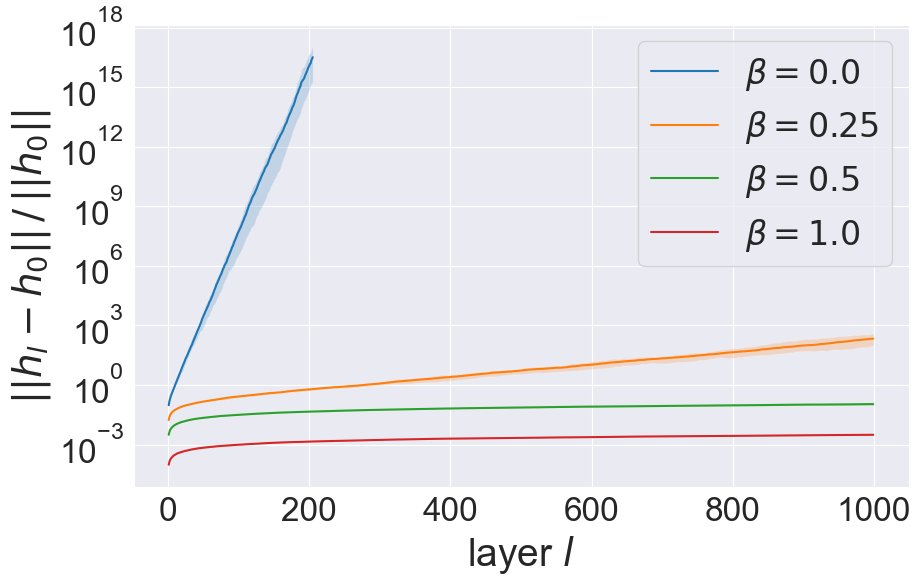

In [11]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
for key, value in ratios.items():
#    if key == 'Gaussian':
#        label = '$\\mathcal{N}(0, 1/d)$'
#    else:
#        label = key
    
    data = pd.DataFrame(value)
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values

    plt.plot(np.arange(1, DEPTH), means, label='$\\beta = {}$'.format(key))
    plt.fill_between(np.arange(1, DEPTH), mins, maxs, alpha=0.2)

plt.xlabel('layer $l$', fontsize=28)
plt.ylabel('$||h_l - h_0 || \, / \, ||h_0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, '.png'))
plt.show()

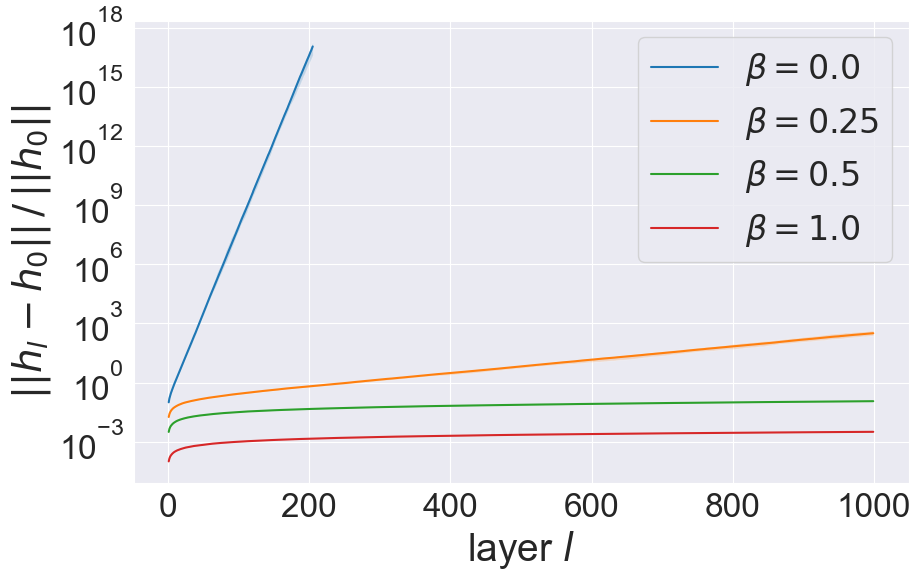

In [11]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
for key, value in ratios.items():
#    if key == 'Gaussian':
#        label = '$\\mathcal{N}(0, 1/d)$'
#    else:
#        label = key
    
    data = pd.DataFrame(value)
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values

    plt.plot(np.arange(1, DEPTH), means, label='$\\beta = {}$'.format(key))
    plt.fill_between(np.arange(1, DEPTH), mins, maxs, alpha=0.2)

plt.xlabel('layer $l$', fontsize=28)
plt.ylabel('$||h_l - h_0 || \, / \, ||h_0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, '.png'))
plt.show()

# He init

In [20]:
ratios = dict()

In [21]:
betas = [0., 0.25, 0.5, 1.0]
all_x = torch.randn(size=(len(betas), N_SAMPLES, INPUT_DIM))
for i, beta in enumerate(betas):
    alpha = DEPTH**(-beta)
    nets = [ResNet(input_dim=INPUT_DIM, width=WIDTH, activation=ACTIVATION, bias=False, alpha=alpha,
                   depth=DEPTH, kind='he', mode='fan_in') for _ in range(N_TRIALS)]
    x = all_x[i, :, :]
    ratios_ = {l: [] for l in range(1, DEPTH)}
    with torch.no_grad():
        for net in nets:
            h = net.input_layer(x)
            h0 = deepcopy(h)

            for l in range(net.depth-1):
                h = net.residual_layers[l](h)
                ratios_[l+1].append(torch.mean(torch.norm(h - h0, dim=1) / torch.norm(h0)).detach().item())
    ratios[beta] = ratios_

nets = [ResNet(input_dim=INPUT_DIM, width=WIDTH, activation=ACTIVATION, bias=False, alpha=1/np.sqrt(WIDTH), 
               depth=DEPTH) for _ in range(N_TRIALS)]
ratios_ = {l: [] for l in range(1, DEPTH)}
with torch.no_grad():
    for net in nets:
        h = net.input_layer(x)
        h0 = deepcopy(h)

        for l in range(net.depth-1):
            h = net.residual_layers[l](h)
            ratios_[l+1].append(torch.mean(torch.norm(h - h0, dim=1) / torch.norm(h0)).detach().item())
ratios['Gaussian'] = ratios_

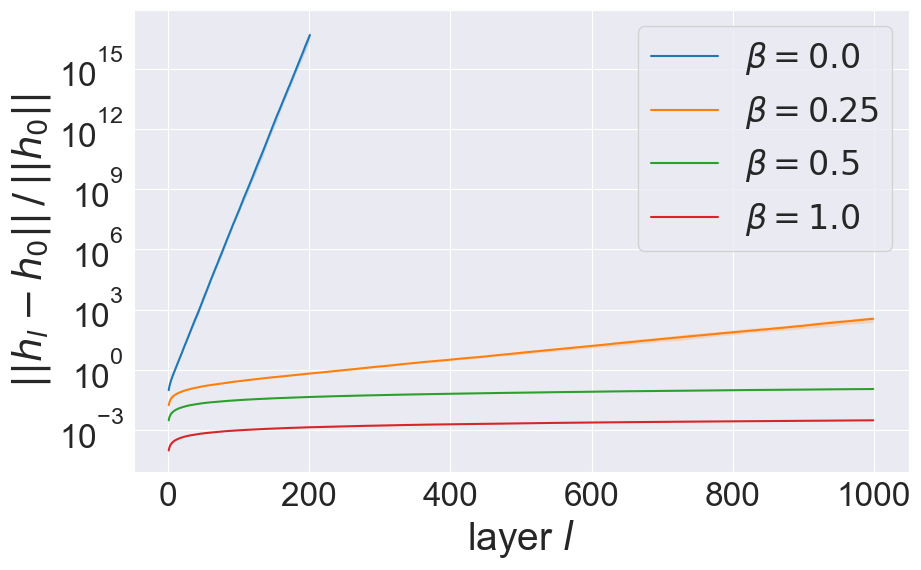

In [22]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
for key, value in ratios.items():
#    if key == 'Gaussian':
#        label = '$\\mathcal{N}(0, 1/d)$'
#    else:
#        label = key
    
    data = pd.DataFrame(value)
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values

    plt.plot(np.arange(1, DEPTH), means, label='$\\beta = {}$'.format(key))
    plt.fill_between(np.arange(1, DEPTH), mins, maxs, alpha=0.2)

plt.xlabel('layer $l$', fontsize=28)
plt.ylabel('$||h_l - h_0 || \, / \, ||h_0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, '.png'))
plt.show()

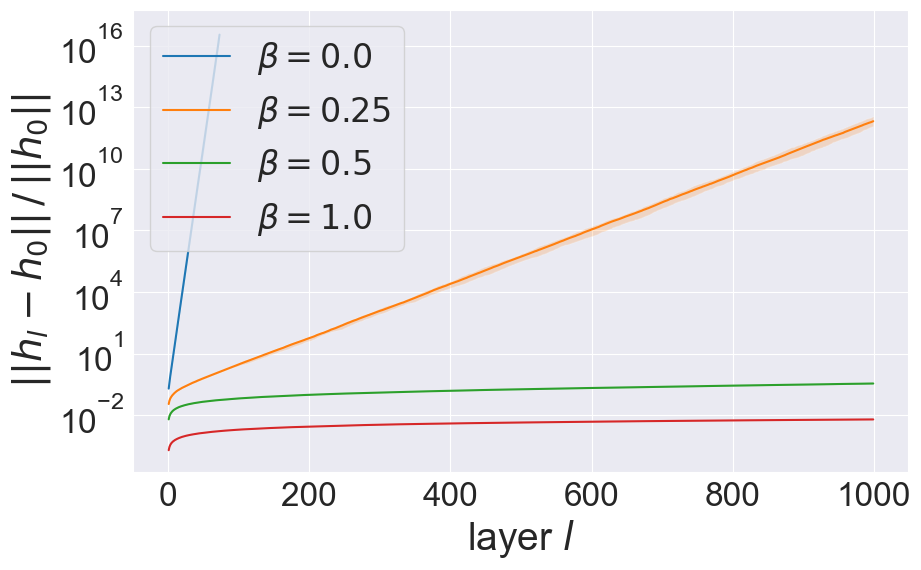

In [13]:
plt.figure(figsize=(10, 6))
plt.yscale('log')
for key, value in ratios.items():
#    if key == 'Gaussian':
#        label = '$\\mathcal{N}(0, 1/d)$'
#    else:
#        label = key
    
    data = pd.DataFrame(value)
    mins = data.min(axis=0).values
    maxs = data.max(axis=0).values
    means = data.mean(axis=0).values

    plt.plot(np.arange(1, DEPTH), means, label='$\\beta = {}$'.format(key))
    plt.fill_between(np.arange(1, DEPTH), mins, maxs, alpha=0.2)

plt.xlabel('layer $l$', fontsize=28)
plt.ylabel('$||h_l - h_0 || \, / \, ||h_0||$', fontsize=28)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.legend(fontsize=24)
#plt.savefig(os.path.join(FIGURES_DIR, '.png'))
plt.show()

# NTK init

# IP init